In [906]:
import numpy as np 
import pandas as pd 
import plotly.express as px
from numpy.linalg import norm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from kmodes.kmodes import KModes

# Probability Calculation of a person having covid 19

## Loading patients Data

In [907]:
patientsDf = pd.read_csv('patients_data.csv')
patientsDf['date_announced'] = pd.to_datetime(patientsDf['date_announced'], errors = 'coerce')
patientsDf['date_announced'] = pd.to_datetime(patientsDf['date_announced'], format='%d/%m/%Y')
patientsDf['status_change_date'] = pd.to_datetime(patientsDf['status_change_date'], format='%d/%m/%Y')
patientsDf['nationality'] = patientsDf['nationality'].replace('Indian', 'India')

In [908]:
patientsDf.head()

,patient_number,state_patient_number,date_announced,age_bracket,gender,detected_city,detected_district,detected_state,state_code,current_status,notes,suspected_contacted_patient,nationality,type_of_transmission,status_change_date,source_1,source_2,source_3,backup_notes
0,1,KL-TS-P1,2020-01-30,20,F,Thrissur,Thrissur,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,Student from Wuhan,NaN
1,2,KL-AL-P1,2020-02-02,NaN,NaN,Alappuzha,Alappuzha,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan
2,3,KL-KS-P1,2020-03-02,NaN,NaN,Kasaragod,Kasaragod,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,Student from Wuhan
3,4,DL-P1,2020-02-03,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,DL,Recovered,"Travelled from Austria, Italy",NaN,India,Imported,2020-03-15,https://www.indiatoday.in/india/story/not-a-ja...,https://economictimes.indiatimes.com/news/poli...,NaN,Travel history to Italy and Austria
4,5,TS-P1,2020-02-03,24,M,Hyderabad,Hyderabad,Telangana,TG,Recovered,"Travelled from Dubai to Bangalore on 20th Feb,...",NaN,India,Imported,2020-03-02,https://www.deccanherald.com/national/south/qu...,https://www.indiatoday.in/india/story/coronavi...,https://www.thehindu.com/news/national/coronav...,"Travel history to Dubai, Singapore contact"


## Checking Nan Values

In [909]:
print(patientsDf.shape, '\n')
print(patientsDf.isna().sum())

(12321, 19) 

patient_number                     0
state_patient_number           10221
date_announced                     0
age_bracket                    10814
gender                          9936
detected_city                  10861
detected_district               2171
detected_state                     0
state_code                         1
current_status                     2
notes                           1191
suspected_contacted_patient    10894
nationality                    11024
type_of_transmission            9380
status_change_date               112
source_1                         191
source_2                        9195
source_3                       11998
backup_notes                   11961
dtype: int64


## Deleting features which don't play in calculating probability

In [910]:
patientsDf = patientsDf.drop(columns=['patient_number', 'state_patient_number', 'date_announced', 'state_code', 'current_status','suspected_contacted_patient','suspected_contacted_patient'])

In [911]:
patientsDf = patientsDf.drop(columns=['source_1', 'source_2', 'source_3', 'backup_notes'])
patientsDf = patientsDf.drop(columns=['status_change_date'])

In [912]:
patientsDf = patientsDf.drop(columns=['detected_city'])

In [913]:
patientsDf = patientsDf.dropna()

In [914]:
patientsDf.shape

(695, 7)

In [915]:
patientsDf.head()

,age_bracket,gender,detected_district,detected_state,notes,nationality,type_of_transmission
0,20,F,Thrissur,Kerala,Travelled from Wuhan,India,Imported
3,45,M,East Delhi,Delhi,"Travelled from Austria, Italy",India,Imported
4,24,M,Hyderabad,Telangana,"Travelled from Dubai to Bangalore on 20th Feb,...",India,Imported
5,69,M,Italians*,Rajasthan,Travelled from Italy,Italy,Imported
20,70,F,Italians*,Rajasthan,"Travelled from Italy, Wife of P6",Italy,Imported


## Analysing Notes

In [916]:
patientsDf['notes'] = patientsDf['notes'].replace('Details Awaited', 'Details awaited')
patientsDf['notes'] = patientsDf['notes'].replace('Travelled from Dubai, UAE', 'Travelled from Dubai')
patientsDf['notes'] = patientsDf['notes'].replace('attended religious event Tablighi Jamaat in delhi', 'Attended Delhi Religious Conference')
patientsDf['notes'] = patientsDf['notes'].replace('Travelled from London', 'Travelled from UK')
patientsDf['notes'] = patientsDf['notes'].replace('Travelled from Dubai.', 'Travelled from Dubai')

In [917]:
patientsDf['notes'].value_counts()

Travelled from Dubai                                                                                                                                                                                                38
Travelled from UK                                                                                                                                                                                                   31
Travelled to Delhi                                                                                                                                                                                                  27
Details awaited                                                                                                                                                                                                     18
Travelled from Delhi                                                                                                                        

In [918]:
temppatientsDf = pd.DataFrame(patientsDf.groupby('notes')['notes'].count().sort_values(ascending=False))
temppatientsDf.columns = ['count']
temppatientsDf = temppatientsDf.reset_index()
temppatientsDf = temppatientsDf[temppatientsDf['notes']!='Details awaited']
temppatientsDf.head(10)
fig = px.bar(temppatientsDf.head(10).sort_values('count', ascending=True), x='count', y='notes', orientation='h', text='count', width=600,
       color_discrete_sequence = ['#35495e'], title='Inital Data notes')
fig.update_xaxes(title='')
fig.update_yaxes(title='')

In [919]:
patientsDf['notes'] = patientsDf['notes'].apply(lambda x: x.lower())

## Making categories in notes
Contact means: The person has come in contact with a +ve covid 19 patient(Usually brother, sister, friend, etc. who has visited abroad e )

In [920]:
patientsDf.notes = patientsDf.notes.apply(lambda x: 'wuhan' if 'wuhan' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'uk' if 'uk' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'uk' if 'scotland' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'uk' if 'london' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'uk' if 'united kingdom' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'usa' if 'usa' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'usa' if 'york' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'usa' if 'us' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'germany' if 'germany' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'denmark' if 'denmark' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'turkey' if 'turkey' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'italy' if 'italy' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'finland' if 'finland' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'spain' if 'spain' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'sri lanka' if 'lanka' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'dubai' if 'dubai' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'singapore' if 'singapore' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'austrialia' if 'australia' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'newZealand' if 'zealand' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'mecca' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'saudi' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'edenburg' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'middle east' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'ireland' if 'ireland' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'sweden' if 'sweden' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'abhudhabi' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'abhu dhabi' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'abu dhabi' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'abu dhabi' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'uae' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'sharjah' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'middleEast' if 'oman' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'iran' if 'iran' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'hidupur' if 'hidupur' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'greece' if 'greece' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'malaysia' if 'malaysia' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'indonesia' if 'indonesia' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'indonesia' if 'indonesian' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'indonesia' if 'mexico' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'qatar' if 'qatar' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'paris' if 'paris' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'netherlands' if 'netherlands' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'sari' if 'sari' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'hadDisease' if 'influenza' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'hadDisease' if 'influenza' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'france' if 'france' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'egypt' if 'egypt' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'thailand' if 'thailand' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'son' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'daughter' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'wife' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'husband' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'uncle' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'driver' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'doctor' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'aunt' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'brother' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'father' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'relative' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'mother' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'neighbour' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'grandmother' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'family' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'roommate' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'parents' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'worker' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'resident' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'related' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'sister' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'pharma' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'police' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'p681' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'contact' if 'contact' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'localTransmission' if 'local' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'localTransmission' if 'locally' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'local' if 'no international' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'bangalore' if 'bangalore' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'kerala' if 'trivendrum' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'bangalore' if 'bengaluru' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'bhopal' if 'bhopal' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'mumbai' if 'mumbai' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'punjab' if 'punjab' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'phuket' if 'phuket' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'delhi' if 'delhi' in x else x)
patientsDf.notes = patientsDf.notes.apply(lambda x: 'history of Travel' if 'history' in x else x)

In [921]:
patientsDf = patientsDf.rename(columns={"notes" :"Travelled from/to or contact"})

In [922]:
patientsDf.head()

,age_bracket,gender,detected_district,detected_state,Travelled from/to or contact,nationality,type_of_transmission
0,20,F,Thrissur,Kerala,wuhan,India,Imported
3,45,M,East Delhi,Delhi,usa,India,Imported
4,24,M,Hyderabad,Telangana,usa,India,Imported
5,69,M,Italians*,Rajasthan,italy,Italy,Imported
20,70,F,Italians*,Rajasthan,italy,Italy,Imported


In [923]:
temp_patientsDf = pd.DataFrame(patientsDf.groupby('Travelled from/to or contact')['Travelled from/to or contact'].count().sort_values(ascending=False))
temp_patientsDf.columns = ['count']
temp_patientsDf = temp_patientsDf.reset_index()
temp_patientsDf = temp_patientsDf[temp_patientsDf['Travelled from/to or contact']!='details awaited']
temp_patientsDf.head(10)
fig = px.bar(temp_patientsDf.head(10).sort_values('count', ascending=True), x='count', y='Travelled from/to or contact', orientation='h', text='count', width=600,
       color_discrete_sequence = ['#35495e'], title='Mining cases info')
fig.update_xaxes(title='')
fig.update_yaxes(title='')

### Removing rows which having awaiting details as travelled from or to

In [924]:
patientsDf = patientsDf[~patientsDf['Travelled from/to or contact'].str.contains("details")]

In [925]:
patientsDf.head()

,age_bracket,gender,detected_district,detected_state,Travelled from/to or contact,nationality,type_of_transmission
0,20,F,Thrissur,Kerala,wuhan,India,Imported
3,45,M,East Delhi,Delhi,usa,India,Imported
4,24,M,Hyderabad,Telangana,usa,India,Imported
5,69,M,Italians*,Rajasthan,italy,Italy,Imported
20,70,F,Italians*,Rajasthan,italy,Italy,Imported


## Analyzing age Bracket

In [926]:
px.histogram(patientsDf, x='age_bracket', color_discrete_sequence = ['#35495e'], nbins=50, title='Distribution of ages of confirmed patients')

In [927]:
patientsDf.age_bracket = patientsDf.age_bracket.apply(lambda x: '30' if '28-35' in x else x)
patientsDf['age_bracket'].values

array(['20', '45', '24', '69', '70', '45', '16', '27', '59', '65', '45',
       '24', '54', '53', '65', '61', '25', '63', '46', '3', '48', '40',
       '47', '13', '96', '89', '3', '85', '46', '70', '68', '27', '69',
       '26', '76', '65', '45', '33', '33', '27', '37', '43', '21', '24',
       '59', '32', '45', '33', '3', '44', '51', '31', '29', '20', '67',
       '63', '49', '26', '68', '52', '22', '18', '34', '28', '25', '22',
       '56', '25', '27', '44', '20', '68', '35', '21', '67', '33', '30',
       '3', '38', '23', '22', '49', '35', '24', '24', '21', '70', '47',
       '32', '21', '51', '19', '65', '22', '22', '32', '22', '69', '58',
       '24', '38', '20', '22', '34', '47', '37', '35', '20', '41', '18',
       '69', '27', '26', '52', '21', '52', '27', '63', '32', '59', '45',
       '22', '24', '27', '60', '32', '53', '20', '23', '42', '74', '28',
       '59', '63', '41', '32', '38', '67', '26', '53', '39', '19', '35',
       '33', '69', '75', '65', '35', '34', '45', '40', 

In [928]:
patientsDf['age_bracket'] = patientsDf['age_bracket'].astype(int)

In [929]:
patientsDf.head()

,age_bracket,gender,detected_district,detected_state,Travelled from/to or contact,nationality,type_of_transmission
0,20,F,Thrissur,Kerala,wuhan,India,Imported
3,45,M,East Delhi,Delhi,usa,India,Imported
4,24,M,Hyderabad,Telangana,usa,India,Imported
5,69,M,Italians*,Rajasthan,italy,Italy,Imported
20,70,F,Italians*,Rajasthan,italy,Italy,Imported


# K-mode clustering
Since features are categorical using k modes instead of kmeans

In [977]:
patientsDf_clust = patientsDf[['age_bracket', 'gender', 'detected_district', 'detected_state', 'Travelled from/to or contact', 'nationality','type_of_transmission']]

In [978]:
patientsDf_clust.head()

,age_bracket,gender,detected_district,detected_state,Travelled from/to or contact,nationality,type_of_transmission
0,20,F,Thrissur,Kerala,wuhan,India,Imported
3,45,M,East Delhi,Delhi,usa,India,Imported
4,24,M,Hyderabad,Telangana,usa,India,Imported
5,69,M,Italians*,Rajasthan,italy,Italy,Imported
20,70,F,Italians*,Rajasthan,italy,Italy,Imported


In [979]:
patientsDf_clust['age_bin'] = pd.cut(patientsDf_clust['age_bracket'], [0, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                              labels=['0-20', '20-30', '30-40', '40-50','50-60','60-70','70-80', '80-90','90-100'])
patientsDf_clust  = patientsDf_clust.drop('age_bracket',axis = 1)

In [980]:
patientsDf_clust.head()

,gender,detected_district,detected_state,Travelled from/to or contact,nationality,type_of_transmission,age_bin
0,F,Thrissur,Kerala,wuhan,India,Imported,0-20
3,M,East Delhi,Delhi,usa,India,Imported,40-50
4,M,Hyderabad,Telangana,usa,India,Imported,20-30
5,M,Italians*,Rajasthan,italy,Italy,Imported,60-70
20,F,Italians*,Rajasthan,italy,Italy,Imported,60-70


In [981]:
patientsDf_clust.describe()

,gender,detected_district,detected_state,Travelled from/to or contact,nationality,type_of_transmission,age_bin
count,676,676,676,676,676,676,676
unique,2,137,27,49,8,4,9
top,M,Bengaluru,Karnataka,contact,India,Local,20-30
freq,469,79,265,222,665,360,165


In [982]:
patientsDf_clust_copy = patientsDf_clust.copy()
patientsDf_clust_copy.head()

,gender,detected_district,detected_state,Travelled from/to or contact,nationality,type_of_transmission,age_bin
0,F,Thrissur,Kerala,wuhan,India,Imported,0-20
3,M,East Delhi,Delhi,usa,India,Imported,40-50
4,M,Hyderabad,Telangana,usa,India,Imported,20-30
5,M,Italians*,Rajasthan,italy,Italy,Imported,60-70
20,F,Italians*,Rajasthan,italy,Italy,Imported,60-70


## Encoding attributes using Label Encoder

In [983]:
le = LabelEncoder()
patientsDf_clust = patientsDf_clust.apply(le.fit_transform)

In [984]:
patientsDf_clust.head()

,gender,detected_district,detected_state,Travelled from/to or contact,nationality,type_of_transmission,age_bin
0,0,122,12,48,0,0,0
3,1,30,5,47,0,0,3
4,1,44,23,47,0,0,1
5,1,46,21,18,2,0,5
20,0,46,21,18,2,0,5


## Using k mode with cao initialization

In [985]:
km_cao = KModes(n_clusters=2, init = "Cao", n_init = 1, verbose=1)


In [986]:
fitClusters_cao = km_cao.fit_predict(patientsDf_clust)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2167.0


In [987]:
fitClusters_cao

array([1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,

In [988]:
clusterCentroidsDf = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroidsDf.columns = patientsDf_clust.columns

In [989]:
clusterCentroidsDf

,gender,detected_district,detected_state,Travelled from/to or contact,nationality,type_of_transmission,age_bin
0,1,14,11,2,0,2,1
1,1,61,12,5,0,0,2


## Using K-Mode with "Huang" initialization

In [990]:
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 1, verbose=1)
fitClusters_huang = km_huang.fit_predict(patientsDf_clust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 129, cost: 2107.0


In [991]:
fitClusters_huang

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,

## Chosing and comparing k

In [992]:
cost = []
for num_clusters in list(range(1,5)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(patientsDf_clust)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2507.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2167.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 50, cost: 2012.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 51, cost: 1940.0


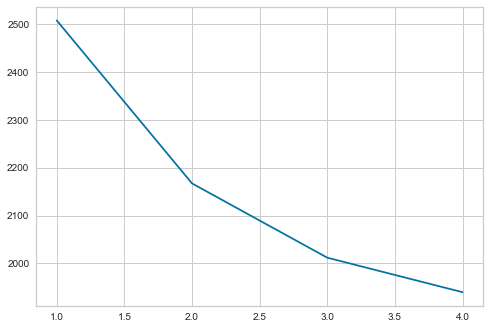

In [993]:
y = np.array([i for i in range(1,5,1)])
plt.plot(y,cost)

In [994]:
km_cao = KModes(n_clusters=2, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(patientsDf_clust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2167.0


In [995]:
fitClusters_cao


array([1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,

## Combining the predicted clusters with original patients data

In [996]:
patientsDf_clust = patientsDf_clust_copy.reset_index()

In [997]:
clustersDf = pd.DataFrame(fitClusters_cao)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([patientsDf_clust, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index', 'level_0'], axis = 1)

In [1024]:
combinedDf.head()


,gender,detected_district,detected_state,Travelled from/to or contact,nationality,type_of_transmission,age_bin,cluster_predicted
0,F,Thrissur,Kerala,wuhan,India,Imported,0-20,1
1,M,East Delhi,Delhi,usa,India,Imported,40-50,1
2,M,Hyderabad,Telangana,usa,India,Imported,20-30,0
3,M,Italians*,Rajasthan,italy,Italy,Imported,60-70,1
4,F,Italians*,Rajasthan,italy,Italy,Imported,60-70,1


In [1025]:
combinedDf.to_csv("patient_data_with_cluster.csv")

In [1000]:
cluster_0 = combinedDf[combinedDf['cluster_predicted'] == 0]
cluster_1 = combinedDf[combinedDf['cluster_predicted'] == 1]

In [1001]:
cluster_0.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 2 to 675
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   gender                        485 non-null    object  
 1   detected_district             485 non-null    object  
 2   detected_state                485 non-null    object  
 3   Travelled from/to or contact  485 non-null    object  
 4   nationality                   485 non-null    object  
 5   type_of_transmission          485 non-null    object  
 6   age_bin                       485 non-null    category
 7   cluster_predicted             485 non-null    uint16  
dtypes: category(1), object(6), uint16(1)
memory usage: 28.3+ KB


In [1002]:
cluster_1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 191 entries, 0 to 658
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   gender                        191 non-null    object  
 1   detected_district             191 non-null    object  
 2   detected_state                191 non-null    object  
 3   Travelled from/to or contact  191 non-null    object  
 4   nationality                   191 non-null    object  
 5   type_of_transmission          191 non-null    object  
 6   age_bin                       191 non-null    category
 7   cluster_predicted             191 non-null    uint16  
dtypes: category(1), object(6), uint16(1)
memory usage: 11.4+ KB


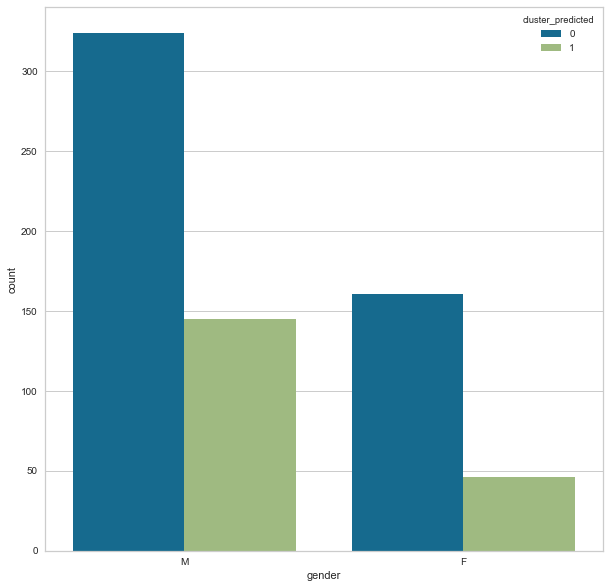

In [1012]:
plt.subplots(figsize = (10,10))
sns.countplot(x=combinedDf['gender'],order=combinedDf['gender'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

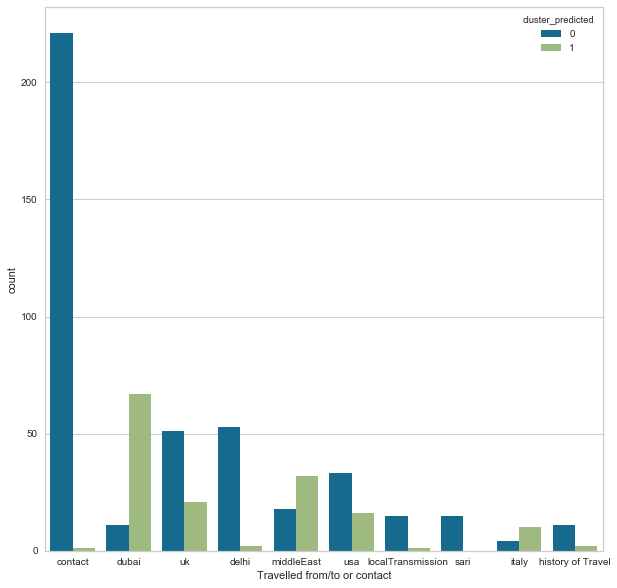

In [1015]:
plt.subplots(figsize = (10,10))
sns.countplot(x=combinedDf['Travelled from/to or contact'],order=combinedDf['Travelled from/to or contact'].value_counts().iloc[:10].index,hue=combinedDf['cluster_predicted'])
plt.show()

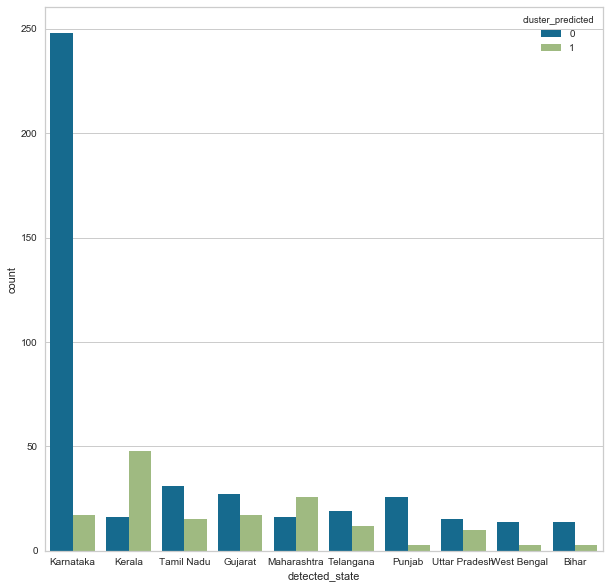

In [1018]:
plt.subplots(figsize = (10,10))
sns.countplot(x=combinedDf['detected_state'],order=combinedDf['detected_state'].value_counts().iloc[:10].index,hue=combinedDf['cluster_predicted'])
plt.show()

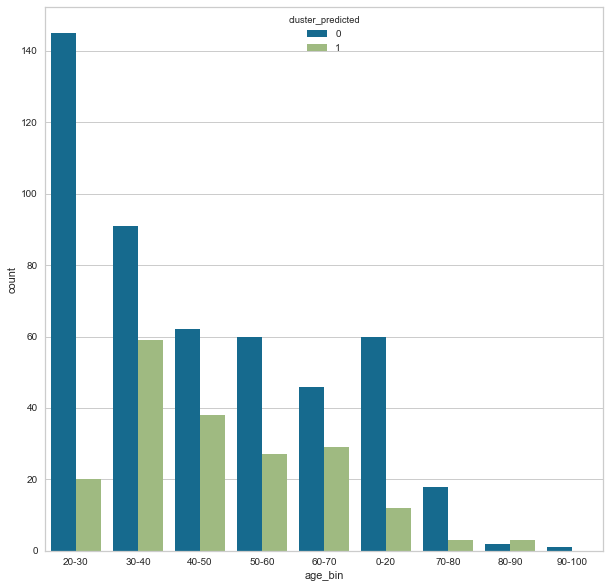

In [1019]:
plt.subplots(figsize = (10,10))
sns.countplot(x=combinedDf['age_bin'],order=combinedDf['age_bin'].value_counts().iloc[:10].index,hue=combinedDf['cluster_predicted'])
plt.show()

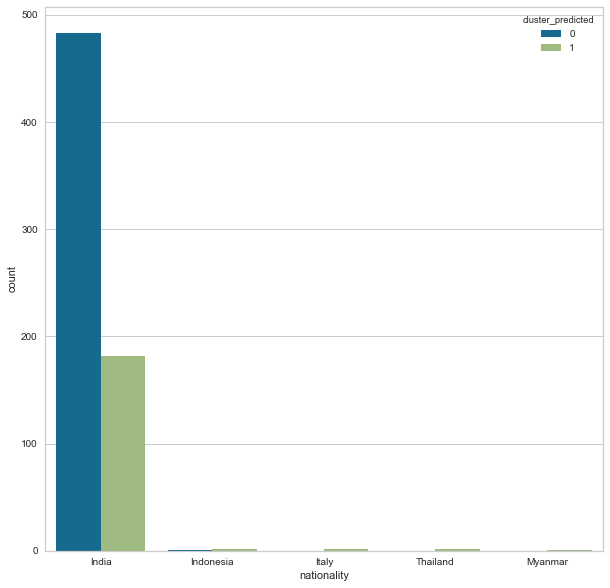

In [1021]:
plt.subplots(figsize = (10,10))
sns.countplot(x=combinedDf['nationality'],order=combinedDf['nationality'].value_counts().iloc[:5].index,hue=combinedDf['cluster_predicted'])
plt.show()

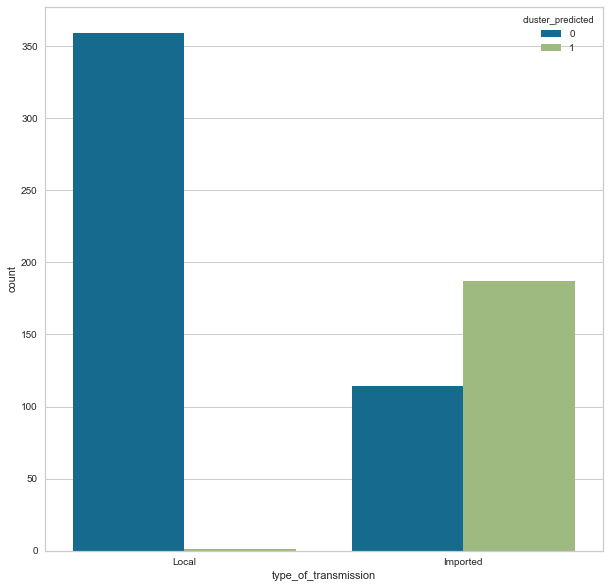

In [1023]:
plt.subplots(figsize = (10,10))
sns.countplot(x=combinedDf['type_of_transmission'],order=combinedDf['type_of_transmission'].value_counts().iloc[:2].index,hue=combinedDf['cluster_predicted'])
plt.show()